# Monte Carlo generated sequences

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from plm_seq_utils import *
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from plm_hamming_dist import vectorized_hamming_distance, energy_corr_array, hamming_dist

In [33]:
filename = 'mc_gen_seqs_w_init_seq_Ns300000_r0.1'
simu_name=filename

cwd = '/Users/marzioformica/Desktop/EPFL/Master/MA2/Labo/my_project/PLM-gen-DCA/Attention-DCA-main'
#cwd=r'C:\Users\youss\OneDrive\Bureau\master epfl\MA2\TP4 De los Rios\git_test\PLM-gen-DCA\Attention-DCA-main'
# Load the generated sequences
output_file = cwd + f'/CODE/AttentionDCA_python/src/PLM/mc_generated_sequences/{filename}.npy'

#output_file = cwd + f'\CODE\AttentionDCA_python\src\PLM\mc_generated_sequences\{filename}.npy'
gen_sequences = np.load(output_file)

Let's filter to keep different only

In [34]:
print(np.shape(gen_sequences))
# Convert each sequence to a tuple to make them hashable
unique_sequences = np.unique([tuple(seq) for seq in gen_sequences], axis=0)

# Now unique_sequences is a numpy array containing only the unique sequences
print(np.shape(unique_sequences)) 

(300000, 63)
(51933, 63)


## PCA

True seqs one-hot shape: (14502, 63, 21)
Gen  seqs one-hot shape: (14502, 63, 21)


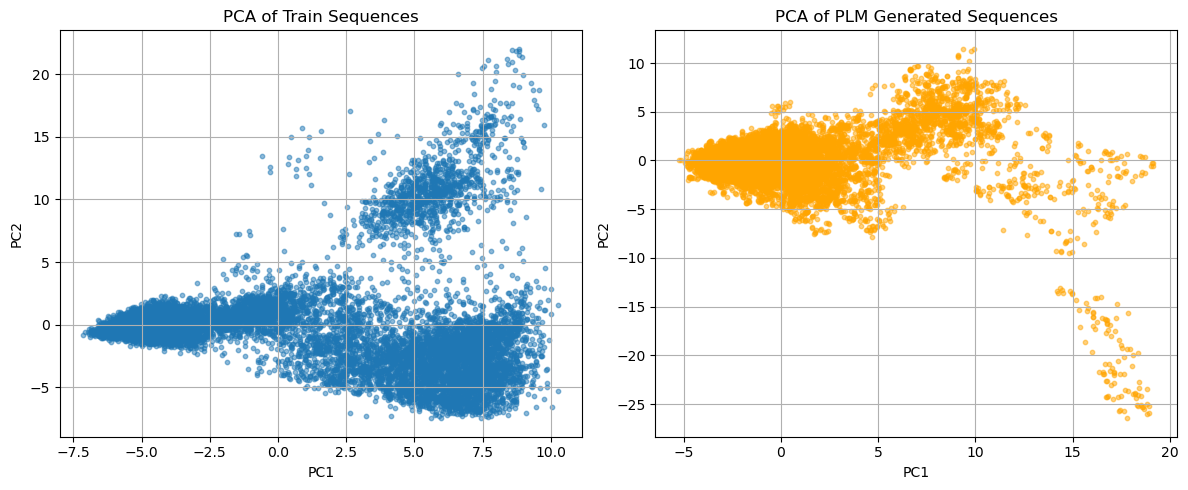

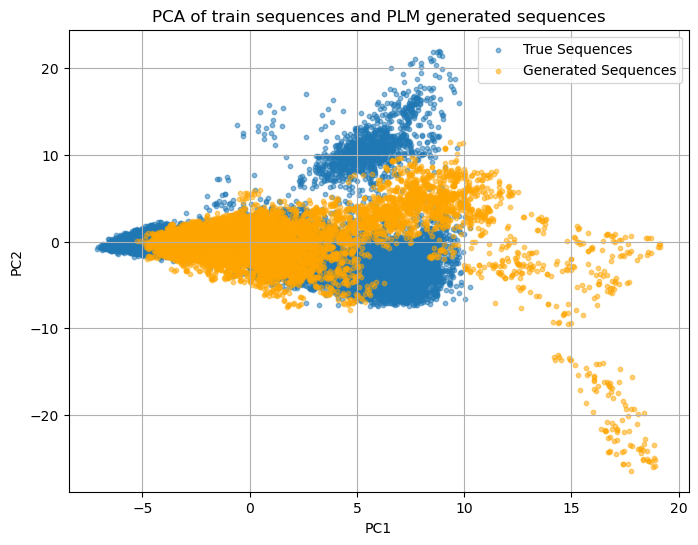

In [43]:
# Load train sequences
family = 'jdoms_bacteria_train2'
filename = cwd + f'/CODE/DataAttentionDCA/jdoms/{family}.fasta'

#filename = cwd + f'\CODE\DataAttentionDCA\jdoms\{family}.fasta'

train_sequences = sequences_from_fasta(filename)
train_sequences_num = [letters_to_nums(seq) for seq in train_sequences]

# One-hot encode the sequences
train_sequences_one_hot = one_hot_seq_batch(train_sequences_num, max_pot=21)

Ni = 10000
Nf = 40000
num_sequences_to_select = len(train_sequences)

# Randomly select indices from the total number of sequences
selected_indices = np.random.choice(len(unique_sequences), size=num_sequences_to_select, replace=False)

# Use these indices to select the corresponding rows from unique_sequences
gen_sequences_pca = unique_sequences[selected_indices]
#gen_sequences_pca = unique_sequences[Ni:Nf]
gen_sequences_one_hot = one_hot_seq_batch(gen_sequences_pca, max_pot=21)

# Print out shapes for sanity check
print("True seqs one-hot shape:", train_sequences_one_hot.shape)
print("Gen  seqs one-hot shape:", gen_sequences_one_hot.shape)

##############################################################
"""
    PCA procedure
"""
# 1. Flatten
gen_flat = gen_sequences_one_hot.reshape(gen_sequences_one_hot.shape[0], -1)
train_flat = train_sequences_one_hot.reshape(train_sequences_one_hot.shape[0], -1)

# 2. Scale separately
scaler_train = StandardScaler()
train_scaled = scaler_train.fit_transform(train_flat)

scaler_gen = StandardScaler()
gen_scaled = scaler_gen.fit_transform(gen_flat)

# 3. PCA separately
pca_train = PCA(n_components=2)
train_pca = pca_train.fit_transform(train_scaled)

pca_gen = PCA(n_components=2)
gen_pca = pca_gen.fit_transform(gen_scaled)

##############################################################
"""
    PCA plots
"""
# Side-by-side PCA plots
plt.figure(figsize=(12, 5))
# Left plot: PCA of True Sequences
plt.subplot(1, 2, 1)
plt.scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.5, s=10)
plt.title("PCA of Train Sequences")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
# Right plot: PCA of Generated Sequences
plt.subplot(1, 2, 2)
plt.scatter(gen_pca[:, 0], gen_pca[:, 1], alpha=0.5, s=10, color='orange')
plt.title("PCA of PLM Generated Sequences")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
# Adjust layout to avoid overlap
plt.tight_layout()
# Save the side-by-side PCA plot
save_path = os.path.join(cwd, 'CODE', 'AttentionDCA_python', 'src', 'PLM', 'results', 'PCA_plots')
if not os.path.exists(save_path):
    os.makedirs(save_path)
# Save PCA plot side-by-side
plt.savefig(save_path + f'/TrainGen_{simu_name}_{Ni}_{Nf}.png')
# After saving, display the plot
plt.show()

# PCA plot both in one graph
plt.figure(figsize=(8, 6))
# Plot both true and generated sequences on the same graph
plt.scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.5, s=10, label='True Sequences')
plt.scatter(gen_pca[:, 0], gen_pca[:, 1], alpha=0.5, s=10, color='orange', label='Generated Sequences')
plt.title("PCA of train sequences and PLM generated sequences")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
# Save the combined PCA plot
plt.savefig(save_path + f'/TrainGen_{simu_name}_{Ni}_{Nf}_onefig.png')
# Display the combined PCA plot
plt.show()

## Hamming distances

The average hamming distance between gillespie and test data is :  40.44035305475107
The standard variation is :  6.805065494425472


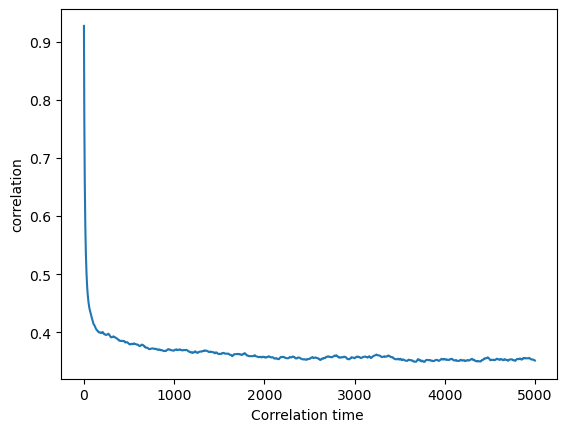

In [36]:
hamming_dists=vectorized_hamming_distance(unique_sequences,np.array(train_sequences_num))
print("The average hamming distance between gillespie and test data is : ",np.mean(hamming_dists))
print("The standard variation is : ", np.std(hamming_dists))
correlation_func=energy_corr_array(unique_sequences,5000)
plt.plot(correlation_func)
plt.xlabel('Correlation time ')
plt.ylabel('correlation')
plt.show()

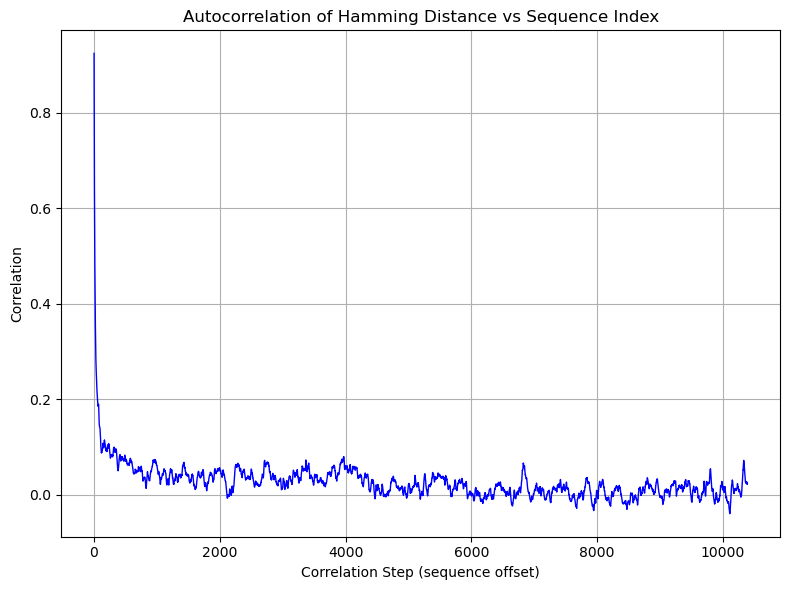

In [37]:
initial_sequence = unique_sequences[0]  # initial sequence you are working with
# Compute Hamming distances sequentially
hamming_distances = []
for seq in unique_sequences:
    distance = hamming_dist(initial_sequence, seq)
    hamming_distances.append(distance)

# Convert the list of distances into a numpy array
hamming_distances = np.array(hamming_distances)

# Correlation:

corr_energy_plot=energy_corr_array(hamming_distances,int(len(hamming_distances)/5))
# X-axis: correlation step (1 to max_cor_step)
x_vals = np.arange(1, len(corr_energy_plot) + 1)

# Plot
plt.figure(figsize=(8, 6))
#plt.plot(x_vals, corr_energy_plot, marker='o', linestyle='-')
plt.plot(x_vals, corr_energy_plot, marker='', linestyle='-', linewidth=1, color='b')
plt.title("Autocorrelation of Hamming Distance vs Sequence Index")
plt.xlabel("Correlation Step (sequence offset)")
plt.ylabel("Correlation")
plt.grid(True)
plt.tight_layout()
plt.show()